Setup

In [23]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

import seaborn as sns
from scipy import stats

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ml-predict-firewall-actions"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Preview unedited data set

In [24]:
import pandas as pd

internet_data = pd.read_csv('internet-firewall-data.csv')

internet_data

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690
65529,54871,445,0,0,drop,70,70,0,1,0,1,0
65530,54870,445,0,0,drop,70,70,0,1,0,1,0


Move 'Action' column to last column

In [25]:
column_to_move = 'Action'

new_column_order = [col for col in internet_data.columns if col != column_to_move] + [column_to_move]

internet_data = internet_data[new_column_order]
internet_data2 = internet_data # copy for correlation matrix later

Rename columns to have consistant format

In [26]:
internet_data.rename(columns={'pkts_sent': 'Packets Sent', 'pkts_received': 'Packets Received'}, inplace=True)

internet_data

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),Packets Sent,Packets Received,Action
0,57222,53,54587,53,177,94,83,2,30,1,1,allow
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9,allow
2,6881,50321,43265,50321,238,118,120,2,1199,1,1,allow
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7,allow
4,50002,443,45848,443,25358,6778,18580,31,16,13,18,allow
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,314,192,122,6,15,4,2,allow
65528,50964,80,13485,80,4680740,67312,4613428,4675,77,985,3690,allow
65529,54871,445,0,0,70,70,0,1,0,1,0,drop
65530,54870,445,0,0,70,70,0,1,0,1,0,drop


We considered combining features but we already have the optimal amount of features for our data; combining features would result in lower accuracy.

Discover and Visualize the data to gain insights

In [27]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Bytes                 65532 non-null  int64 
 5   Bytes Sent            65532 non-null  int64 
 6   Bytes Received        65532 non-null  int64 
 7   Packets               65532 non-null  int64 
 8   Elapsed Time (sec)    65532 non-null  int64 
 9   Packets Sent          65532 non-null  int64 
 10  Packets Received      65532 non-null  int64 
 11  Action                65532 non-null  object
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


Based on our dataset info, there are no missing values that we need to consider.

In [28]:
internet_data["Action"].value_counts()

Action
allow         37640
deny          14987
drop          12851
reset-both       54
Name: count, dtype: int64

In [29]:
internet_data.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),Packets Sent,Packets Received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


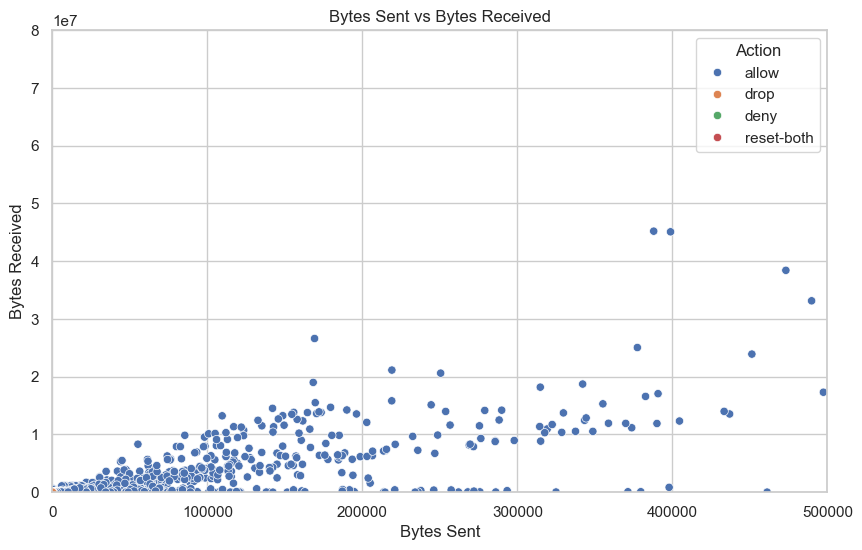

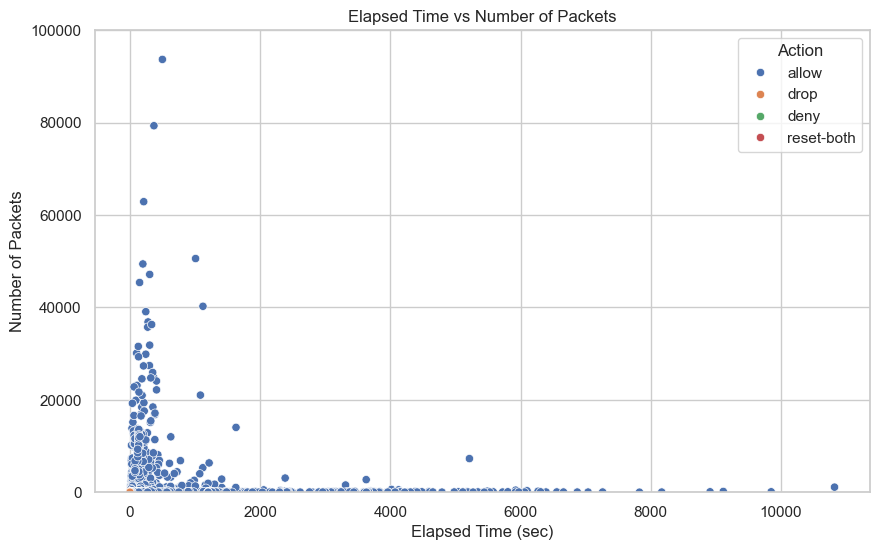

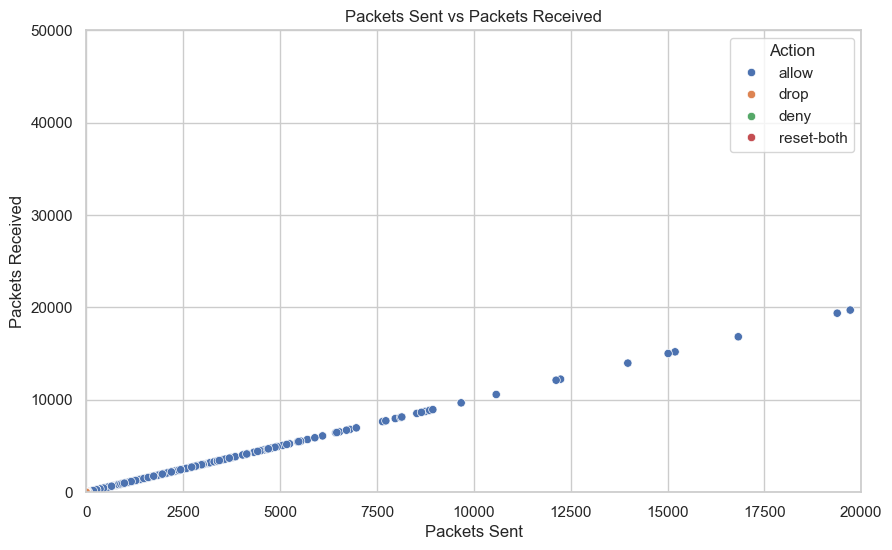

In [30]:
sns.set(style="whitegrid")

# Plot 1: Bytes Sent vs Bytes Received
plt.figure(figsize=(10, 6))
plt.title("Bytes Sent vs Bytes Received")
plt.xlabel("Bytes Sent")
plt.ylabel("Bytes Received")
plot = sns.scatterplot(x="Bytes Sent", y="Bytes Received", data=internet_data, hue="Action")
plot.set(ylim=(0, 80000000))
plot.set(xlim=(0, 500000))
plt.show()

# Plot 2: Elapsed Time (sec) vs Packets
plt.figure(figsize=(10, 6))
plt.title("Elapsed Time vs Number of Packets")
plt.xlabel("Elapsed Time (sec)")
plt.ylabel("Number of Packets")
plot = sns.scatterplot(x="Elapsed Time (sec)", y="Packets", data=internet_data, hue="Action")
plot.set(ylim=(0, 100000))
plt.show()

# Plot 3: Packet Sent vs Packet Received
plt.figure(figsize=(10, 6))
plt.title("Packets Sent vs Packets Received")
plt.xlabel("Packets Sent")
plt.ylabel("Packets Received")
plot = sns.scatterplot(x="Packets Sent", y="Packets Sent", data=internet_data, hue="Action")
plot.set(ylim=(0, 50000))
plot.set(xlim=(0, 20000))
plt.show()

Use Label Encoding to convert the 'Action' feature from categorical to numerical

In [31]:
internet_data['Action'] = internet_data['Action'].astype('category').cat.codes

# Calculate Pearson correlation
correlation_matrix1 = internet_data.corr(method='pearson')
correlation_matrix1

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),Packets Sent,Packets Received,Action
Source Port,1.000000,-0.332246,0.145391,-0.024843,0.000221,-0.000931,0.001950,-0.001742,-0.046515,-0.001422,-0.001962,0.038343
Destination Port,-0.332246,1.000000,-0.281676,0.410042,-0.005297,0.001675,-0.014684,-0.006063,0.023537,-0.002134,-0.010909,0.095110
NAT Source Port,0.145391,-0.281676,1.000000,0.178435,0.010659,0.002242,0.020827,0.012633,0.141485,0.007180,0.018772,-0.686893
NAT Destination Port,-0.024843,0.410042,0.178435,1.000000,0.003975,0.007904,-0.003216,0.004605,0.219776,0.006136,0.001747,-0.214765
Bytes,0.000221,-0.005297,0.010659,0.003975,1.000000,0.933462,0.830225,0.974379,0.148834,0.966548,0.850209,-0.013546
Bytes Sent,-0.000931,0.001675,0.002242,0.007904,0.933462,1.000000,0.575047,0.887596,0.126039,0.973976,0.639098,-0.004570
Bytes Received,0.001950,-0.014684,0.020827,-0.003216,0.830225,0.575047,1.000000,0.843067,0.143601,0.690959,0.946039,-0.023794
Packets,-0.001742,-0.006063,0.012633,0.004605,0.974379,0.887596,0.843067,1.000000,0.147074,0.961286,0.916978,-0.015562
Elapsed Time (sec),-0.046515,0.023537,0.141485,0.219776,0.148834,0.126039,0.143601,0.147074,1.000000,0.135101,0.143954,-0.170684
Packets Sent,-0.001422,-0.002134,0.007180,0.006136,0.966548,0.973976,0.690959,0.961286,0.135101,1.000000,0.771550,-0.009842


Use One-Hot Encoding to convert the 'Action' feature from categorical to numerical

In [32]:
internet_data_one_hot = pd.get_dummies(internet_data2, columns=['Action'])

# Calculate Pearson correlation
correlation_matrix2 = internet_data_one_hot.corr(method='pearson')
correlation_matrix2

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),Packets Sent,Packets Received,Action_0,Action_1,Action_2,Action_3
Source Port,1.000000,-0.332246,0.145391,-0.024843,0.000221,-0.000931,0.001950,-0.001742,-0.046515,-0.001422,-0.001962,0.132189,-0.386728,0.247548,-0.042674
Destination Port,-0.332246,1.000000,-0.281676,0.410042,-0.005297,0.001675,-0.014684,-0.006063,0.023537,-0.002134,-0.010909,-0.367960,0.687862,-0.271009,0.022247
NAT Source Port,0.145391,-0.281676,1.000000,0.178435,0.010659,0.002242,0.020827,0.012633,0.141485,0.007180,0.018772,0.754348,-0.477127,-0.433486,-0.016482
NAT Destination Port,-0.024843,0.410042,0.178435,1.000000,0.003975,0.007904,-0.003216,0.004605,0.219776,0.006136,0.001747,0.235859,-0.149221,-0.135458,-0.005655
Bytes,0.000221,-0.005297,0.010659,0.003975,1.000000,0.933462,0.830225,0.974379,0.148834,0.966548,0.850209,0.014869,-0.009405,-0.008532,-0.000496
Bytes Sent,-0.000931,0.001675,0.002242,0.007904,0.933462,1.000000,0.575047,0.887596,0.126039,0.973976,0.639098,0.005017,-0.003172,-0.002879,-0.000167
Bytes Received,0.001950,-0.014684,0.020827,-0.003216,0.830225,0.575047,1.000000,0.843067,0.143601,0.690959,0.946039,0.026119,-0.016522,-0.014986,-0.000871
Packets,-0.001742,-0.006063,0.012633,0.004605,0.974379,0.887596,0.843067,1.000000,0.147074,0.961286,0.916978,0.017083,-0.010806,-0.009802,-0.000566
Elapsed Time (sec),-0.046515,0.023537,0.141485,0.219776,0.148834,0.126039,0.143601,0.147074,1.000000,0.135101,0.143954,0.187367,-0.118522,-0.107503,-0.006238
Packets Sent,-0.001422,-0.002134,0.007180,0.006136,0.966548,0.973976,0.690959,0.961286,0.135101,1.000000,0.771550,0.010804,-0.006834,-0.006199,-0.000356


Correlation Matrix Heatmap

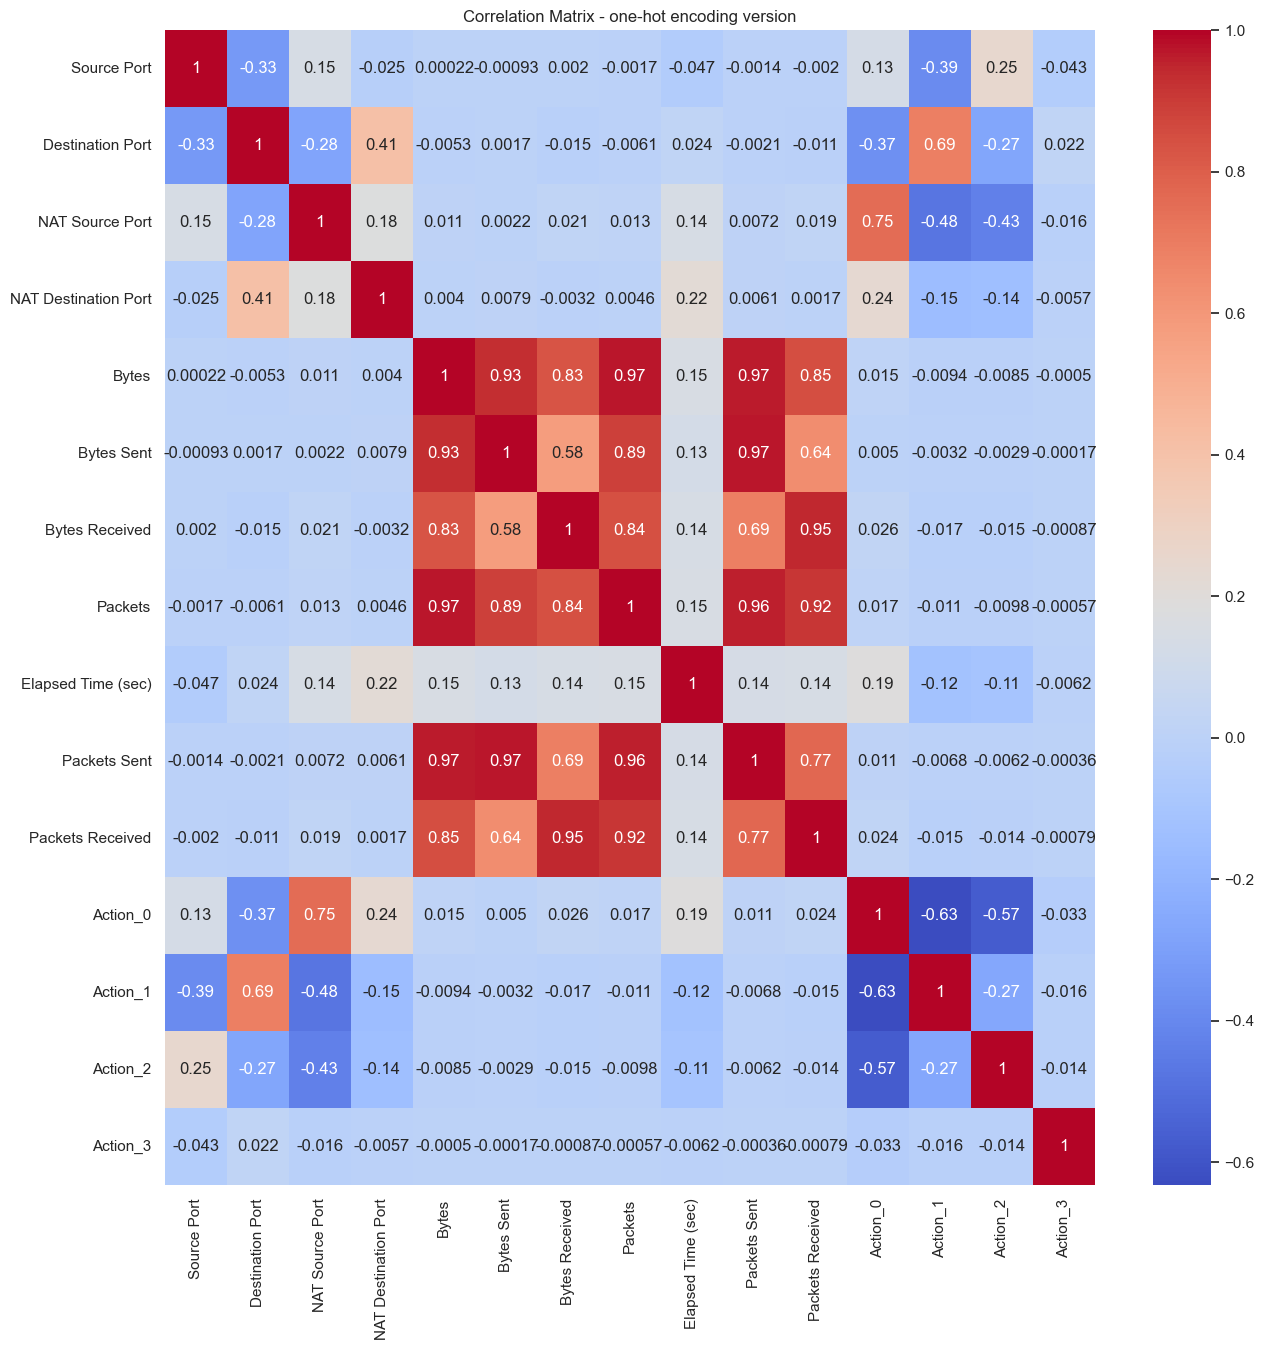

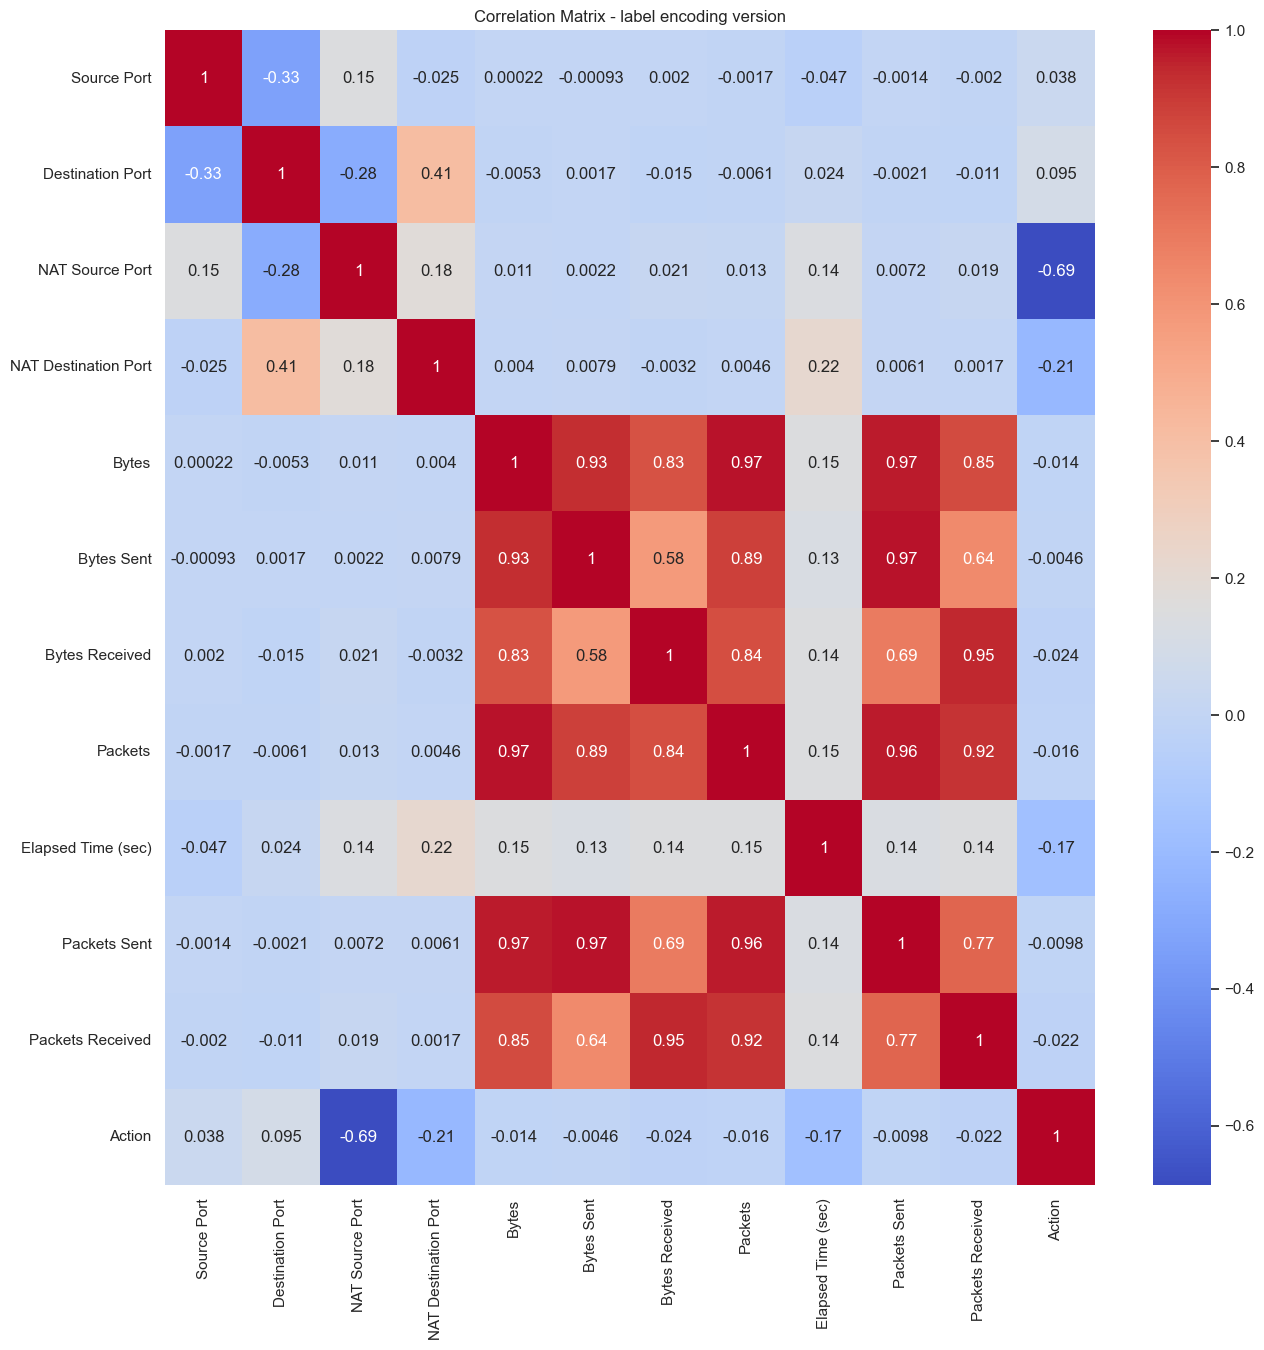

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Show heatmap for one-hot encoding correlation matrix
plt.figure(figsize=(15, 15))
plt.title("Correlation Matrix - one-hot encoding version")
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm')
plt.show()

# Show heatmap for label encoding correlation matrix
plt.figure(figsize=(15, 15))
plt.title("Correlation Matrix - label encoding version")
sns.heatmap(correlation_matrix1, annot=True, cmap='coolwarm')
plt.show()

Verify that 'Bytes' equals 'Bytes Sent' plus 'Bytes Received' so we can eliminate this column.
This is necessary so we don't have extra weight in our data based on the Bytes features.

In [34]:
internet_data_new = internet_data[['Bytes Sent', 'Bytes Received', 'Bytes']].copy()
internet_data_new['Cal Total Bytes'] = internet_data_new['Bytes Sent'] + internet_data_new['Bytes Received']
internet_data_new['Valid Bytes'] = internet_data_new['Cal Total Bytes'] == internet_data_new['Bytes']
internet_data_new

,Bytes Sent,Bytes Received,Bytes,Cal Total Bytes,Valid Bytes
0,94,83,177,177,True
1,1600,3168,4768,4768,True
2,118,120,238,238,True
3,1438,1889,3327,3327,True
4,6778,18580,25358,25358,True
...,...,...,...,...,...
65527,192,122,314,314,True
65528,67312,4613428,4680740,4680740,True
65529,70,0,70,70,True
65530,70,0,70,70,True


Verify that 'Packets' equals 'Packets Sent' plus 'Packets Sent' so we can eliminate this column.
This is necessary so we don't have extra weight in our data based on the Packets features.

In [35]:
internet_data_new = internet_data[['Packets Sent', 'Packets Received', 'Packets']].copy()
internet_data_new['Cal Total Packets'] = internet_data_new['Packets Sent'] + internet_data_new['Packets Received']
internet_data_new['Valid Packets'] = internet_data_new['Cal Total Packets'] == internet_data_new['Packets']
internet_data_new

,Packets Sent,Packets Received,Packets,Cal Total Packets,Valid Packets
0,1,1,2,2,True
1,10,9,19,19,True
2,1,1,2,2,True
3,8,7,15,15,True
4,13,18,31,31,True
...,...,...,...,...,...
65527,4,2,6,6,True
65528,985,3690,4675,4675,True
65529,1,0,1,1,True
65530,1,0,1,1,True


In [36]:
internet_data = internet_data.drop('Bytes', axis=1)
internet_data = internet_data.drop('Packets', axis=1)
internet_data

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes Sent,Bytes Received,Elapsed Time (sec),Packets Sent,Packets Received,Action
0,57222,53,54587,53,94,83,30,1,1,0
1,56258,3389,56258,3389,1600,3168,17,10,9,0
2,6881,50321,43265,50321,118,120,1199,1,1,0
3,50553,3389,50553,3389,1438,1889,17,8,7,0
4,50002,443,45848,443,6778,18580,16,13,18,0
...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,192,122,15,4,2,0
65528,50964,80,13485,80,67312,4613428,77,985,3690,0
65529,54871,445,0,0,70,0,0,1,0,2
65530,54870,445,0,0,70,0,0,1,0,2


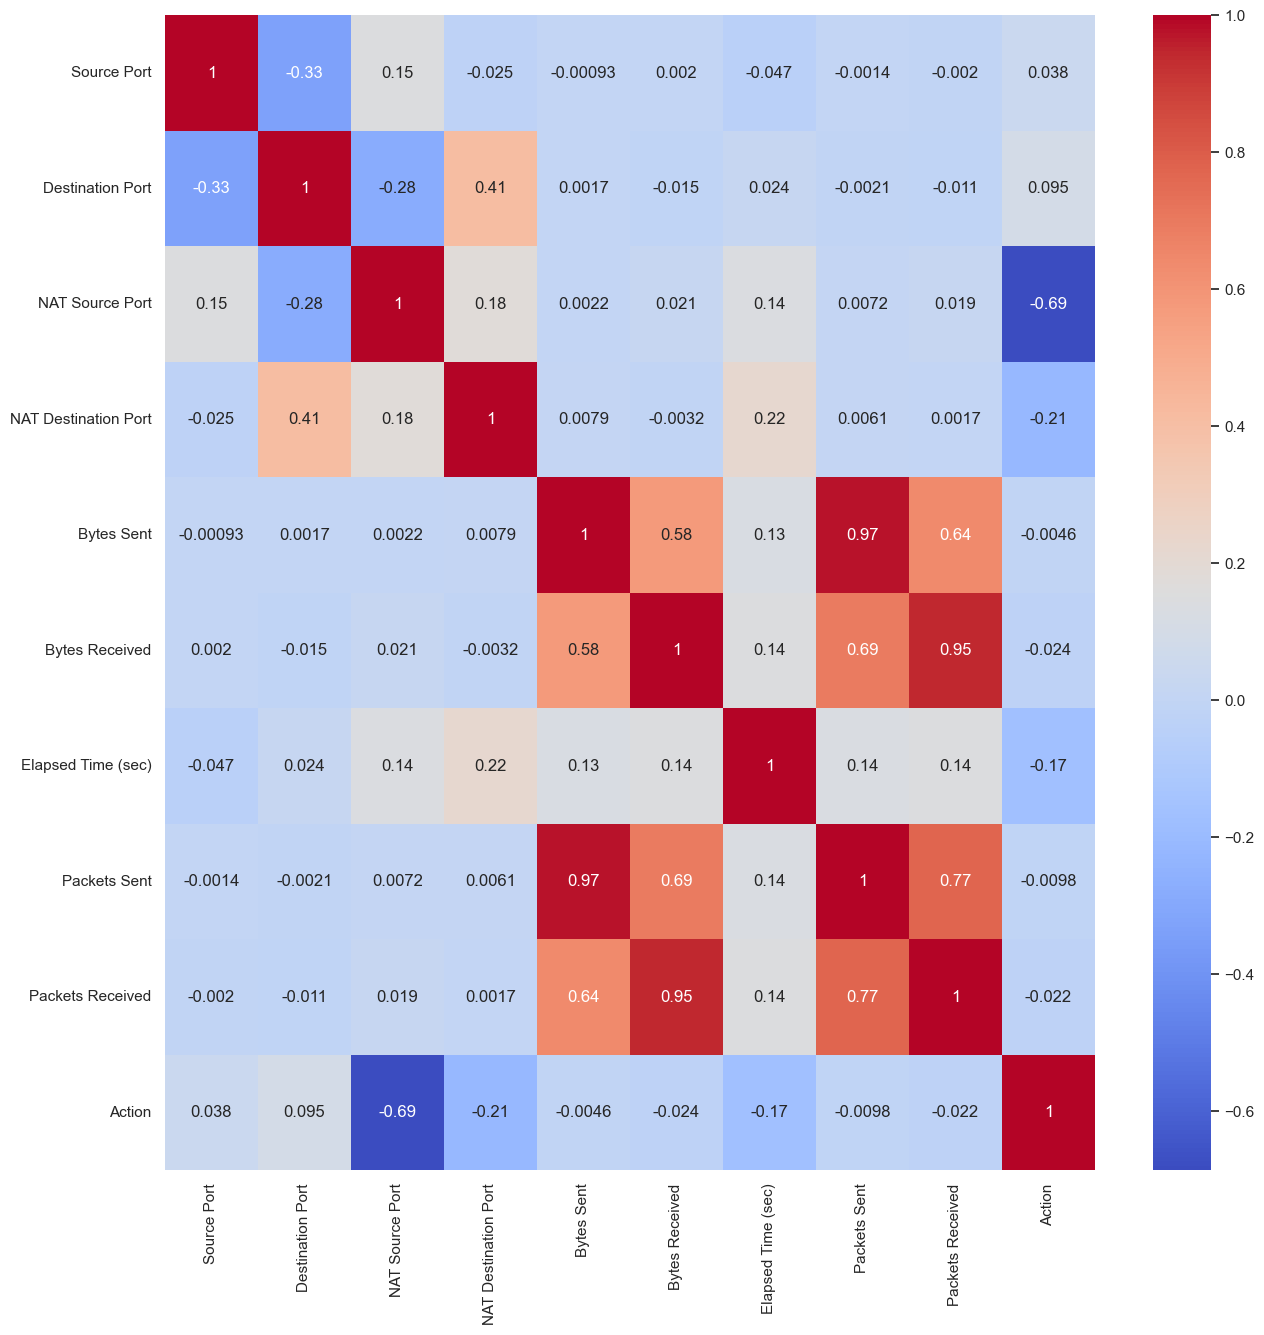

In [37]:
correlation_matrix1 = internet_data.corr(method='pearson')
import seaborn as sns
import matplotlib.pyplot as plt

# Show heatmap for one-hot encoding correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix1, annot=True, cmap='coolwarm')
plt.show()

Plot features that may need to be scaled/normalized

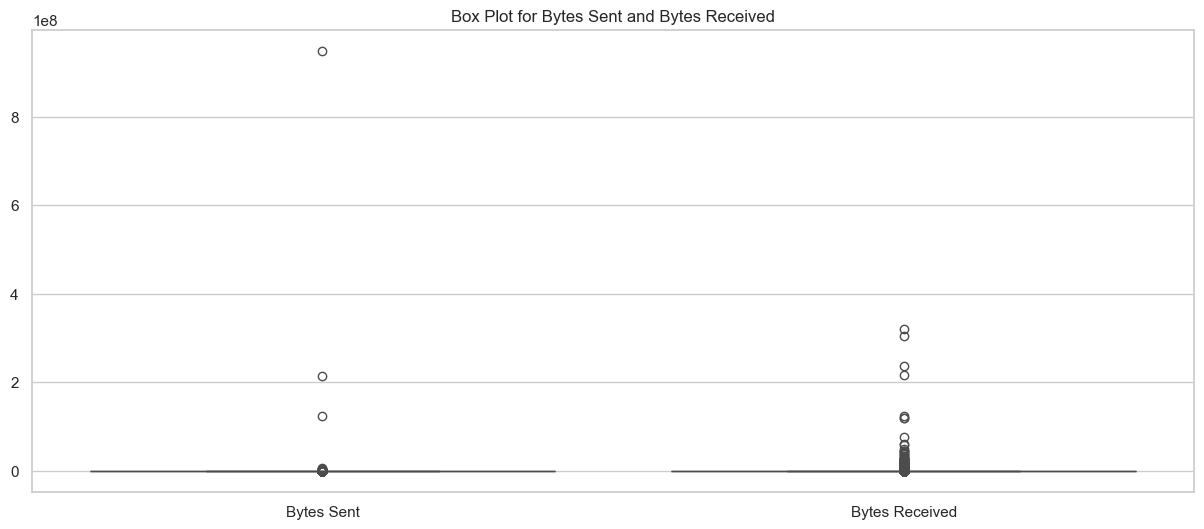

In [38]:
columns_to_plot = ['Bytes Sent', 'Bytes Received']

plt.figure(figsize=(15, 6))
sns.boxplot(data=internet_data[columns_to_plot])
plt.title('Box Plot for Bytes Sent and Bytes Received')
plt.show()

Implement Standardization and Normalization for Bytes Sent and Bytes Received

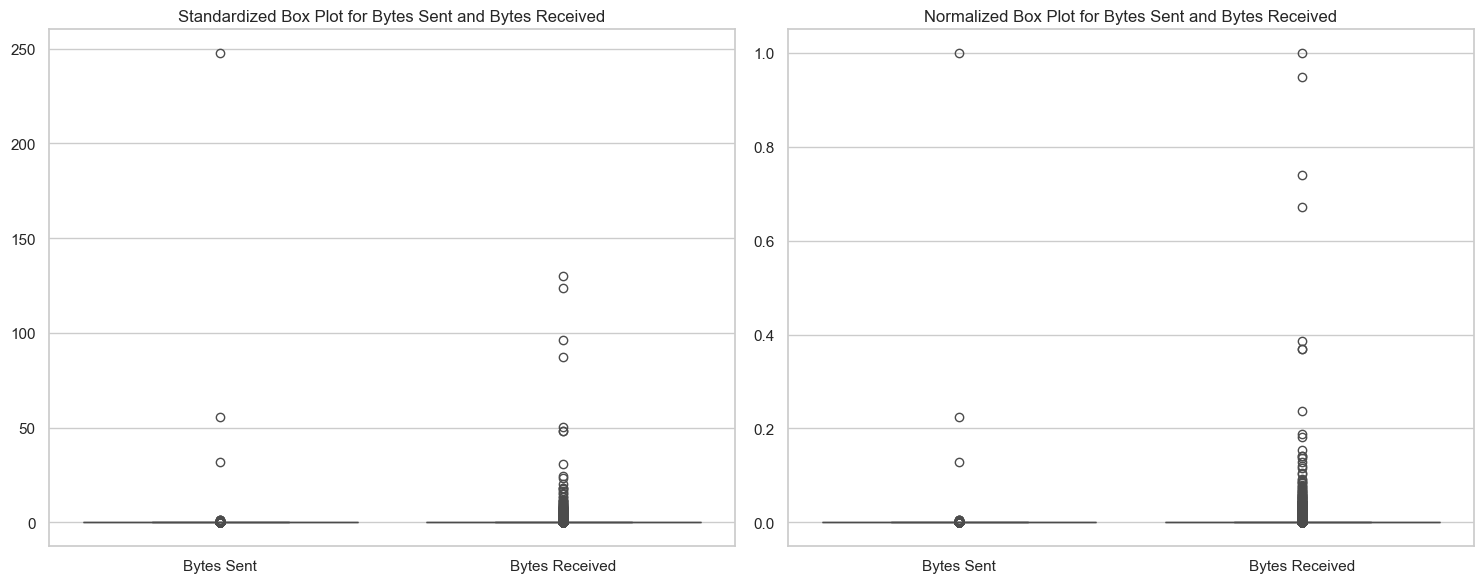

In [39]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

columns_to_scale = ['Bytes Sent', 'Bytes Received']

# 1. Standardization
scaler = StandardScaler()
standardized_data = scaler.fit_transform(internet_data[columns_to_scale])
standardized_df = pd.DataFrame(standardized_data, columns=columns_to_scale)

# 2. Normalization
normalizer = MinMaxScaler()
normalized_data = normalizer.fit_transform(internet_data[columns_to_scale])
normalized_df = pd.DataFrame(normalized_data, columns=columns_to_scale)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=standardized_df)
plt.title('Standardized Box Plot for Bytes Sent and Bytes Received')

plt.subplot(1, 2, 2)
sns.boxplot(data=normalized_df)
plt.title('Normalized Box Plot for Bytes Sent and Bytes Received')

plt.tight_layout()
plt.show()

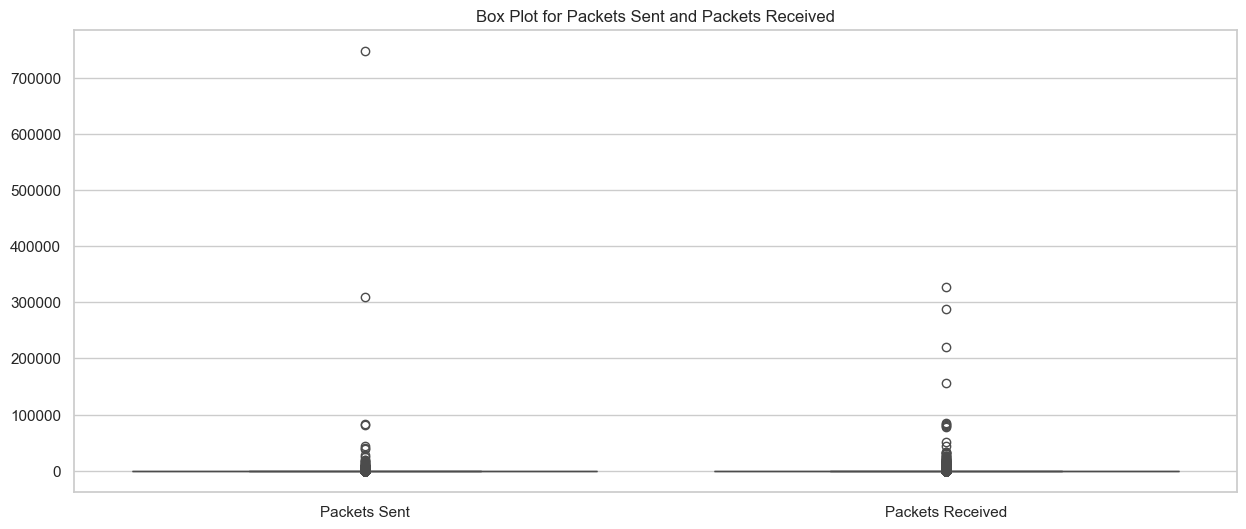

In [40]:
columns_to_plot = ['Packets Sent', 'Packets Received']

plt.figure(figsize=(15, 6))
sns.boxplot(data=internet_data[columns_to_plot])
plt.title('Box Plot for Packets Sent and Packets Received')
plt.show()

Implement Standardization for Packets Sent and Packets Received

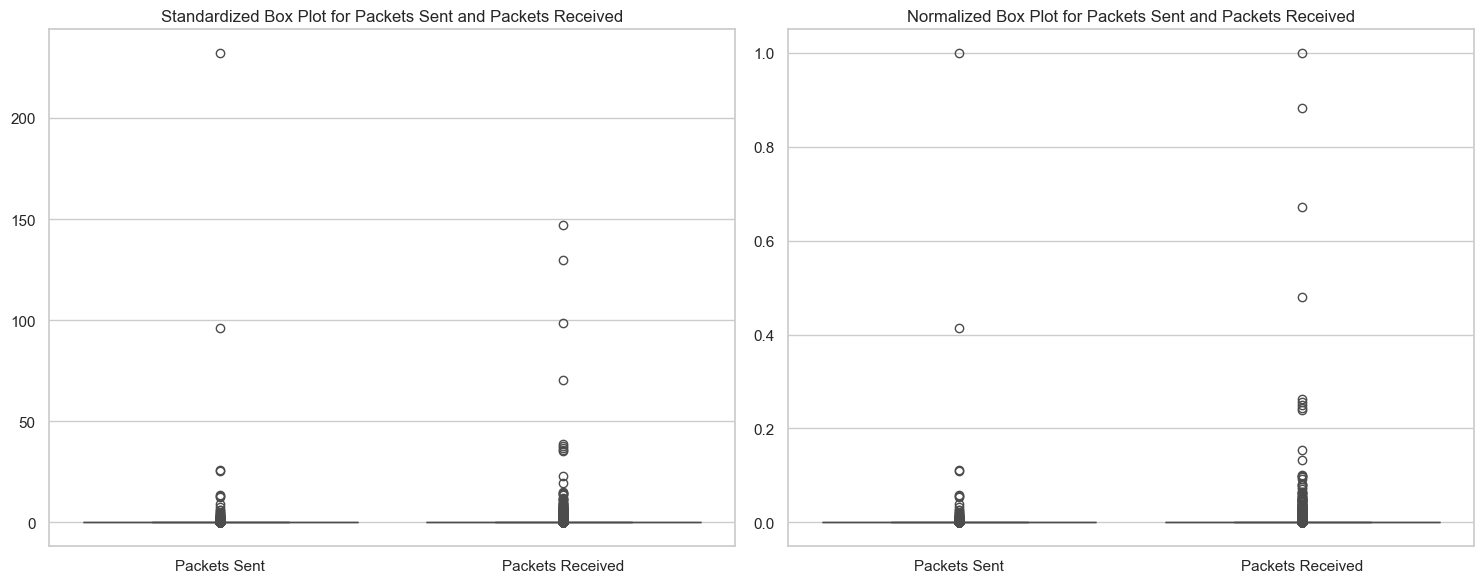

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

columns_to_scale = ['Packets Sent', 'Packets Received']

# 1. Standardization
scaler = StandardScaler()
standardized_data = scaler.fit_transform(internet_data[columns_to_scale])
standardized_df = pd.DataFrame(standardized_data, columns=columns_to_scale)

# 2. Normalization
normalizer = MinMaxScaler()
normalized_data = normalizer.fit_transform(internet_data[columns_to_scale])
normalized_df = pd.DataFrame(normalized_data, columns=columns_to_scale)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=standardized_df)
plt.title('Standardized Box Plot for Packets Sent and Packets Received')

plt.subplot(1, 2, 2)
sns.boxplot(data=normalized_df)
plt.title('Normalized Box Plot for Packets Sent and Packets Received')

plt.tight_layout()
plt.show()

Perform log transformation on the bytes sent and bytes received

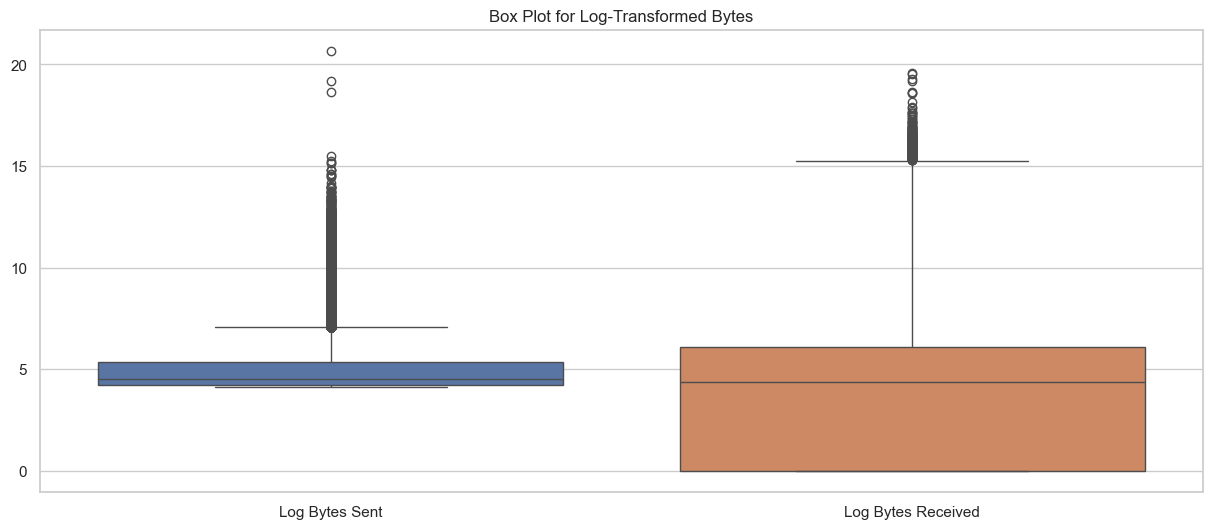

In [42]:
internet_data_logged_data = internet_data.copy()
internet_data_logged_data['Log Bytes Sent'] = np.log1p(internet_data['Bytes Sent'])
internet_data_logged_data['Log Bytes Received'] = np.log1p(internet_data['Bytes Received'])

log_columns_to_plot = ['Log Bytes Sent', 'Log Bytes Received']

plt.figure(figsize=(15,6))
sns.boxplot(data=internet_data_logged_data[log_columns_to_plot])
plt.title('Box Plot for Log-Transformed Bytes')
plt.show()

Perform log transformation on packets sent and packets received

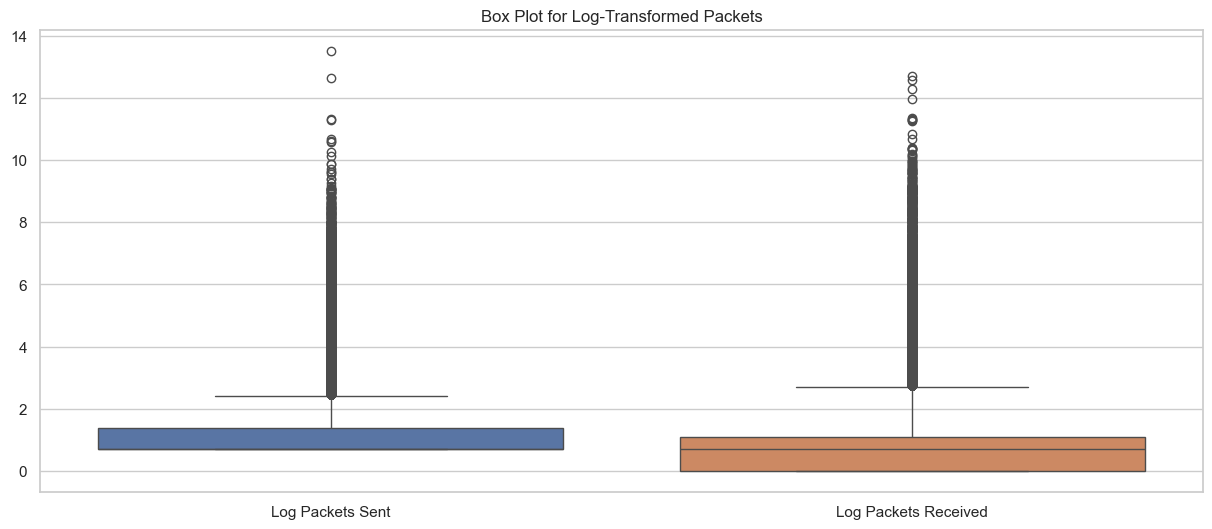

In [43]:
internet_data_logged_data['Log Packets Sent'] = np.log1p(internet_data['Packets Sent'])
internet_data_logged_data['Log Packets Received'] = np.log1p(internet_data['Packets Received'])

log_columns_to_plot = ['Log Packets Sent', 'Log Packets Received']

plt.figure(figsize=(15,6))
sns.boxplot(data=internet_data_logged_data[log_columns_to_plot])
plt.title('Box Plot for Log-Transformed Packets')
plt.show()

We notice that there are still outliers after performing a log transofrmation of the bytes sent and bytes received, as well as packets sent and packets received. Since we're analyzing internet traffic data, very large or very small values (in terms of bytes sent/received) might represent legitimate high-usage events or anomalies. Removing or altering these could distort the real insights.

Plot a normal distribution curve on the logged bytes data for further visualization.

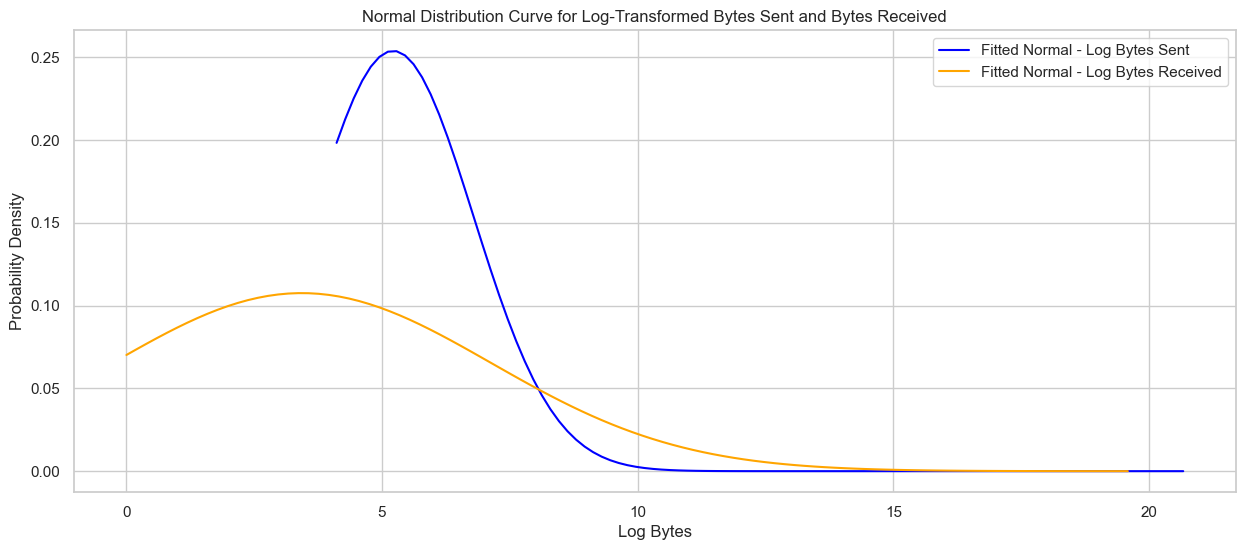

In [44]:
from scipy.stats import norm

# Fit a normal distribution for the log-transformed 'Bytes Sent'
mean_log_sent, std_log_sent = norm.fit(internet_data_logged_data['Log Bytes Sent'])

# Fit a normal distribution for the log-transformed 'Bytes Received'
mean_log_received, std_log_received = norm.fit(internet_data_logged_data['Log Bytes Received'])

# Create a range of values from min to max for the log-transformed data
x_log_sent = np.linspace(internet_data_logged_data['Log Bytes Sent'].min(), internet_data_logged_data['Log Bytes Sent'].max(), 100)
x_log_received = np.linspace(internet_data_logged_data['Log Bytes Received'].min(), internet_data_logged_data['Log Bytes Received'].max(), 100)

# Calculate the PDF for log-transformed data
pdf_log_sent = norm.pdf(x_log_sent, mean_log_sent, std_log_sent)
pdf_log_received = norm.pdf(x_log_received, mean_log_received, std_log_received)

plt.figure(figsize=(15, 6))

plt.plot(x_log_sent, pdf_log_sent, label='Fitted Normal - Log Bytes Sent', color='blue')

plt.plot(x_log_received, pdf_log_received, label='Fitted Normal - Log Bytes Received', color='orange')

plt.title('Normal Distribution Curve for Log-Transformed Bytes Sent and Bytes Received')
plt.xlabel('Log Bytes')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [46]:
internet_data_logged_data['Bytes Sent'] = internet_data_logged_data['Log Bytes Sent']
internet_data_logged_data.drop(columns=['Log Bytes Sent'], inplace=True)
internet_data_logged_data['Bytes Received'] = internet_data_logged_data['Log Bytes Received']
internet_data_logged_data.drop(columns=['Log Bytes Received'], inplace=True)
internet_data_logged_data['Packets Sent'] = internet_data_logged_data['Log Packets Sent']
internet_data_logged_data.drop(columns=['Log Packets Sent'], inplace=True)
internet_data_logged_data['Packets Received'] = internet_data_logged_data['Log Packets Received']
internet_data_logged_data.drop(columns=['Log Packets Received'], inplace=True)

In [47]:
internet_data_logged_data

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes Sent,Bytes Received,Elapsed Time (sec),Packets Sent,Packets Received,Action
0,57222,53,54587,53,4.553877,4.430817,30,0.693147,0.693147,0
1,56258,3389,56258,3389,7.378384,8.061171,17,2.397895,2.302585,0
2,6881,50321,43265,50321,4.779123,4.795791,1199,0.693147,0.693147,0
3,50553,3389,50553,3389,7.271704,7.544332,17,2.197225,2.079442,0
4,50002,443,45848,443,8.821585,9.829895,16,2.639057,2.944439,0
...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,5.262690,4.812184,15,1.609438,1.098612,0
65528,50964,80,13485,80,11.117109,15.344482,77,6.893656,8.213653,0
65529,54871,445,0,0,4.262680,0.000000,0,0.693147,0.000000,2
65530,54870,445,0,0,4.262680,0.000000,0,0.693147,0.000000,2


In [50]:
preprocessed_internet_data=internet_data_logged_data.copy()
preprocessed_internet_data.to_csv('preprocessed_internet_data.csv', index=False)